# Dogs vs Cats

### (A first project to put together what I learned about PyTorch.) 

_With three convolution and one fully-connected layers, on a subset of 2,000 samples (out of the 25,000 present in the dataset), what is the best accuracy we can get?_
 
 ## A few words about the features/parameters of the model
 
For each new feature implemented, I ran the algorithm a couple times with different data samples and initialization weights before I made a decision. Each decision is a tradeoff between convergence speed and overfitting.
 
1. A "vanilla" convolutional neural network, with images resized to 128 x 128 pixels but no further transformation, would sometimes not converge at all (presumably hitting a local minimum); this was fixed by playing with the learning rate / momentum, and initialization of the weights. We settle on a learning rate of 0.01 and momentum of 0.09.
2. Standardizing the dataset (by subtracting mean / dividing by standard deviation of pixels) yields a better (and steadier) convergence rate. A training accuracy of 99% and a loss < 0.1 is reached after about 25 epochs. Without any regularization parameters, however, validation accuracy starts decreasing after this. It hovers around 67-68%, while validation loss shoots up. One explanation could be that the model starts assigning a higher probability to missclassified images as it starts overfitting the training set.
3. [Batch normalization](http://proceedings.mlr.press/v37/ioffe15.pdf) gives a second sizeable boost in convergence, but not in accuracy. The model hits a training loss <0.1 and 99+% training accuracy after just 5 epochs. The validation loss/accuracy do not improve much after that, as expected. Maximum validation accuracy is stuck around 70%.
4. [Data augmentation](https://dataaspirant.com/data-augmentation-techniques-deep-learning/), in the form of random flips and random rotations, gives a much-needed accuracy improvement: the model smashes the 70% validation accuracy barrier, with a maximum validation accuracy around 76-77% in some cases. The convergence rate drops, however, and by the 30th epoch, we're still well below 95% training accuracy; choosing a larger learning rate (0.05) improves the convergence rate. Curiously, random erasure of some pixels did not improve the model's generalization abilities: although the training accuracy grew steadily with the number of epochs, the validation accuracy stagnated around 74-75% early on.
5. A dropout of 0.25 on each layer improves generalization; both the training and validation accuracy grow together, and the losses decrease together. The convergence is much slower, as expected (in fact, the whole algorithm is much slower). Note that at this point, the accuracy/loss curves start looking how they should: the validation accuracy (resp. loss) grows (resp. decreases) steadily with the training accuracy/loss, instead of oscillating seemingly randomly during the training process. Moreover, the validation loss finally breaks the 0.5 barrier. An interesting side-effect of dropout is that during the earlier epochs, the validation accuracy is frequently higher than the training accuracy (since we use all neurons to test our model on the validation set).
5. Switching the [gradient descent algorithm](https://ruder.io/optimizing-gradient-descent/index.html) from basic stochastic gradient descent to Adam (an adaptive one) speeds up the convergence. A maximum accuracy of 77-78% is consistently reached after 16-18 epochs, but does not seem to improve much after that (although the validation loss does decrease somewhat).
9. Early stopping. To avoid overfitting our model, we save its parameters every time the validation loss decreases. We keep the best model after 30 epochs.



---
# Packages

In [2]:
# PyTorch stuff
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data.sampler import SubsetRandomSampler

# Other things
import os
import numpy as np 
import pandas as pd 
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import PIL
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

---
# 1. Load the data

In [7]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

100%|█████████████████████████████████████████| 814M/814M [30:59<00:00, 631kB/s]
100%|█████████████████████████████████████████| 814M/814M [30:59<00:00, 459kB/s]


In [5]:
!unzip input/test.zip;
!unzip input/train.zip;       

Archive:  input/test.zip
   creating: test/
  inflating: test/1.jpg              
  inflating: test/10.jpg             
  inflating: test/100.jpg            
  inflating: test/1000.jpg           
  inflating: test/10000.jpg          
  inflating: test/10001.jpg          
  inflating: test/10002.jpg          
  inflating: test/10003.jpg          
  inflating: test/10004.jpg          
  inflating: test/10005.jpg          
  inflating: test/10006.jpg          
  inflating: test/10007.jpg          
  inflating: test/10008.jpg          
  inflating: test/10009.jpg          
  inflating: test/1001.jpg           
  inflating: test/10010.jpg          
  inflating: test/10011.jpg          
  inflating: test/10012.jpg          
  inflating: test/10013.jpg          
  inflating: test/10014.jpg          
  inflating: test/10015.jpg          
  inflating: test/10016.jpg          
  inflating: test/10017.jpg          
  inflating: test/10018.jpg          
  inflating: test/10019.jpg          
  infl

In [3]:
# Data paths
train_dir = "./train"
test_dir = "./test"

Make a dataframe with our image names and labels; the image names start with either 'dog' or 'cat' so the labels can be extracted directly.

In [4]:
df = pd.DataFrame()
df['image'] = pd.Series(data=os.listdir(train_dir))
df['label'] = df['image'].apply(lambda x: int(x.startswith('d')))
df.head()

,image,label
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [5]:
df['label'].value_counts()

1    12500
0    12500
Name: label, dtype: int64

We have 50% of cat pictures and 50% of dog pictures. Here's our custom dataset class:

In [6]:
class CreateDataset(Dataset):
    def __init__(self, df, data_dir='./', transform=None):
        super().__init__()
        self.df = df.values
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name)
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
        

### Image preprocessing

1. We resize the images to $150\times 150$ pixels; although this does not preserve the pictures' aspect ratio, it is preferable to reducing the largest side to $150$ and padding the other side, since then the model has to learn that a large black rectangle is not significant for classification.
2. We also standardize each channel by subtracting the mean and dividing by the standard deviation over all the dataset; computing these takes a while as each image has to be opened and loaded to compute the stats, so I'm recording these for further reference and hardcoding them in my normalization step: $$\mu = (0.488, 0.455, 0.417), \quad \sigma = (0.259, 0.253, 0.256)$$
3. We perform some data augmentation by randomly flipping and rotating some images by 10 degrees.

In [7]:
mean = np.zeros(3)
sum2 = np.zeros(3)
total_pixels = np.zeros(3) 
count = 0.0


for file in os.listdir(train_dir):
        count += 1
        img = Image.open(train_dir + '/' + file)
        stats = PIL.ImageStat.Stat(img)
        mean += stats.mean
        sum2 += stats.sum2
        total_pixels += stats.count

mean = mean / count  
std = np.sqrt(sum2 / total_pixels - mean ** 2)

# Pixel values in our dataset will actually range from 0 to 1
mean_norm = mean / 255
std_norm = std / 255
        
print(mean_norm, std_norm)

[0.48832284 0.45508163 0.41695606] [0.25869595 0.25273686 0.25611359]


In [8]:
image_size = 128

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.RandomErasing(),
    transforms.Normalize((0.488,0.455,0.417), (0.259,0.253,0.256))
    ])

transform_valid = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.488,0.455,0.417), (0.259,0.253,0.256))
    ])

Create a train/validation split with 20% validation, and do the same with a toy dataset (because I don't have the resources to train a model on the whole dataset)

In [9]:
train_df, valid_df = train_test_split(df,
                                     stratify=df['label'],
                                     random_state=1,
                                     test_size=0.2)
train_df_baby, valid_df_baby = train_test_split(df,
                                         stratify=df['label'],
                                         random_state=1,
                                         train_size=2000,
                                         test_size=500)

In [10]:
train_data = CreateDataset(train_df, train_dir, transform_train)
valid_data = CreateDataset(valid_df, train_dir, transform_valid)

train_data_baby = CreateDataset(train_df_baby, train_dir, transform_train)
valid_data_baby = CreateDataset(valid_df_baby, train_dir, transform_valid)

In [11]:
batch_size = 100
train_loader = DataLoader(train_data, batch_size=batch_size)
valid_loader = DataLoader(valid_data, batch_size=batch_size)

batch_size_baby = 25
train_loader_baby = DataLoader(train_data_baby, batch_size=batch_size_baby)
valid_loader_baby = DataLoader(valid_data_baby, batch_size=batch_size_baby)

Let's display a few of our images; I corrected the pixel values (to account for normalization) but the colors will still appear a bit weird.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

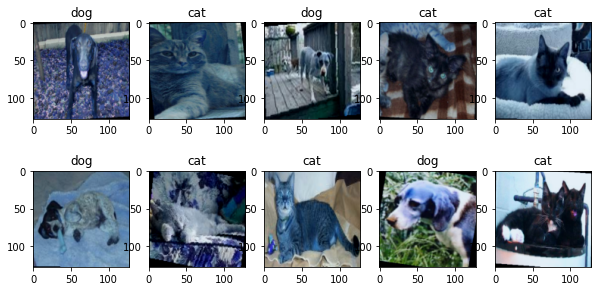

In [12]:
labels = ['cat', 'dog']

fig, axes = plt.subplots(2, 5, figsize=(10,5))

for i in range(len(axes.flat)):
    axes.flat[i].imshow(np.transpose((train_data_baby[i][0] * 0.25 + 0.4), (1, 2, 0)))
    axes.flat[i].set(title=labels[train_data_baby[i][1]])

---
# 2. Define the model

We'll use three convolution layers with maxpooling.

In [42]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # input 128x128x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        self.conv1_bn = nn.BatchNorm2d(32)
        
        # input 64x64x32 after conv + maxpool
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')
        self.conv2_bn = nn.BatchNorm2d(32)
        
        # input 32x32x32 after conv + maxpool
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv3.weight, nonlinearity='relu')
        self.conv3_bn = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2, stride=2)
        
        # input 16x16x64
        self.fc1 = nn.Linear(16 * 16 * 64, 64)
        self.fc1_bn = nn.BatchNorm1d(64)
        
        self.fc2 = nn.Linear(64, 2)
        
        self.drop2d = nn.Dropout2d(p=0.25)
        self.drop = nn.Dropout(p=0.27)
        
    def forward(self, x):
        x = self.drop2d(self.conv1(x))
        x = self.pool(F.relu(self.conv1_bn(x)))
        x = self.drop2d(self.conv2(x))
        x = self.pool(F.relu(self.conv2_bn(x)))
        x = self.drop2d(self.conv3(x))
        x = self.pool(F.relu(self.conv3_bn(x))) 
        x = x.view(-1, 16 * 16* 64)    
        x = self.drop(self.fc1(x))
        x = F.relu(self.fc1_bn(x))
        x = self.fc2(x)
        
        return x

In [43]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=64, bias=True)
  (fc1_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (drop2d): Dropout2d(p=0.25, inplace=False)
  (drop): Dropout(p=0.27, inplace=False)
)


In [44]:
#model.load_state_dict(torch.load('best_model_dropout027.pt'))

# 3. Train the model

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [46]:
epochs = 30

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_loss_min = np.Inf

for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0
          
    model.train()
    batch_number = 0
    for data, target in train_loader_baby:
        batch_number += 1
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
        _, yhat = torch.max(output.data, 1)
        train_accuracy += (yhat == target).sum().item() 

    model.eval()
    for data, target in valid_loader_baby:
        output = model(data)
        loss = criterion(output, target)
        
        valid_loss += loss.item() * data.size(0)
        _, yhat = torch.max(output.data, 1)
        valid_accuracy += (yhat == target).sum().item()
        
    train_loss = train_loss / len(train_loader_baby.sampler)
    valid_loss = valid_loss / len(valid_loader_baby.sampler)
    train_accuracy = train_accuracy / len(train_loader_baby.sampler)
    valid_accuracy = valid_accuracy / len(valid_loader_baby.sampler)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.3f}% \tValidation Accuracy: {:.3f}%'.format(
        epoch, train_loss, valid_loss, train_accuracy * 100, valid_accuracy * 100))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'best_model_dropout025.pt')
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 0.690734 	Validation Loss: 0.649721 
		Training Accuracy: 57.000% 	Validation Accuracy: 60.400%
Validation loss decreased (inf --> 0.649721).  Saving model ...
Epoch: 1 	Training Loss: 0.645602 	Validation Loss: 0.638430 
		Training Accuracy: 62.200% 	Validation Accuracy: 60.200%
Validation loss decreased (0.649721 --> 0.638430).  Saving model ...
Epoch: 2 	Training Loss: 0.621842 	Validation Loss: 0.622003 
		Training Accuracy: 66.150% 	Validation Accuracy: 63.600%
Validation loss decreased (0.638430 --> 0.622003).  Saving model ...
Epoch: 3 	Training Loss: 0.597037 	Validation Loss: 0.596010 
		Training Accuracy: 68.200% 	Validation Accuracy: 68.000%
Validation loss decreased (0.622003 --> 0.596010).  Saving model ...
Epoch: 4 	Training Loss: 0.602275 	Validation Loss: 0.606206 
		Training Accuracy: 67.300% 	Validation Accuracy: 66.000%
Epoch: 5 	Training Loss: 0.583228 	Validation Loss: 0.594342 
		Training Accuracy: 68.550% 	Validation Accuracy: 67.200%
Val

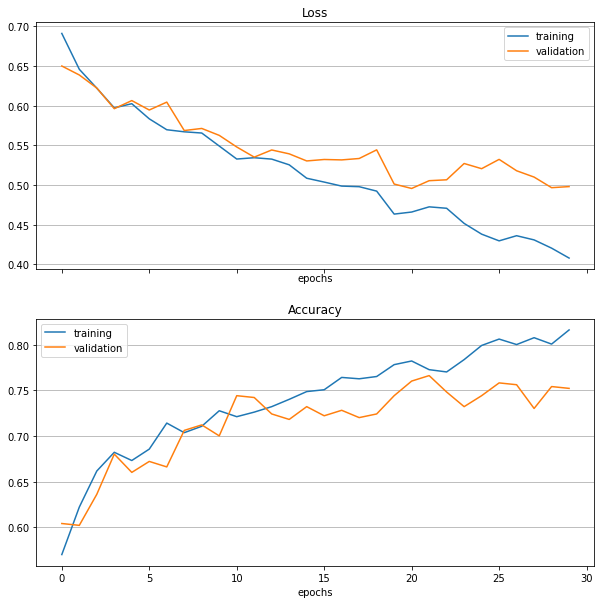

In [47]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax1, ax2 = axes
    
ax1.plot(list(range(epochs)), train_losses, label='training')
ax1.plot(list(range(epochs)), valid_losses, label='validation')
ax1.set(title='Loss', xlabel='epochs')
ax1.grid(axis='y')
ax1.legend()


ax2.plot(list(range(epochs)), train_accuracies, label='training')
ax2.plot(list(range(epochs)), valid_accuracies, label='validation')
ax2.set(title="Accuracy", xlabel='epochs')
ax2.grid(axis='y')
plt.legend();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


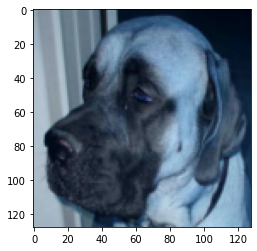

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class: 0
predicted probability: 0.5126358866691589
actual value: 1



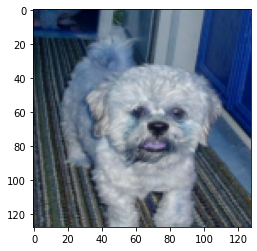

predicted class: 0
predicted probability: 0.8579254746437073
actual value: 1



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


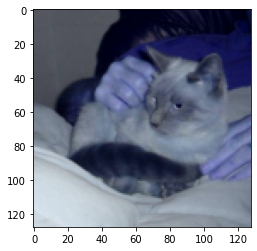

predicted class: 1
predicted probability: 0.5711207389831543
actual value: 0



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


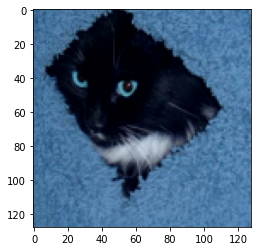

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class: 1
predicted probability: 0.7824630737304688
actual value: 0



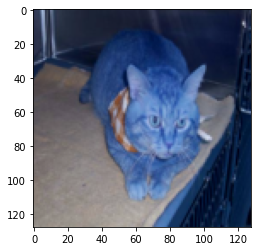

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class: 1
predicted probability: 0.7954604625701904
actual value: 0



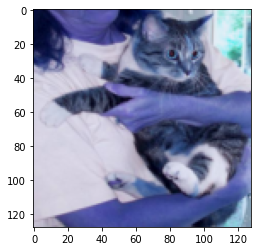

predicted class: 1
predicted probability: 0.6315547227859497
actual value: 0



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


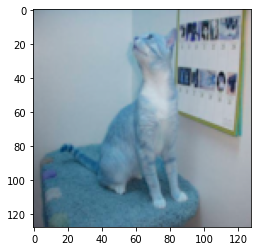

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class: 1
predicted probability: 0.6188326478004456
actual value: 0



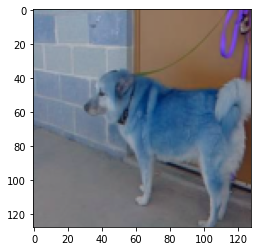

predicted class: 0
predicted probability: 0.7372443675994873
actual value: 1



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


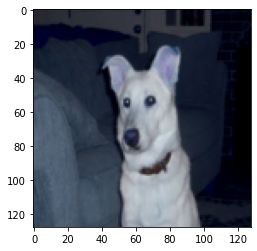

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class: 0
predicted probability: 0.5518278479576111
actual value: 1



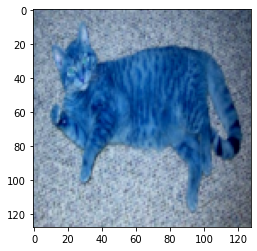

predicted class: 1
predicted probability: 0.9431196451187134
actual value: 0



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


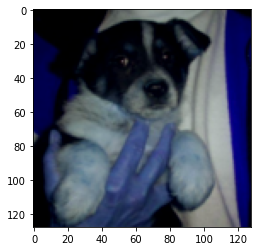

predicted class: 0
predicted probability: 0.7028727531433105
actual value: 1



In [52]:
count = 0
i = 0
soft = nn.Softmax(dim=1)
while count <= 10:
    x, y = valid_data_baby[i]
    z = model(x.view(1, 3, 128, 128))
    _, yhat = z.max(1)
    if yhat != y:
        plt.imshow(np.transpose(x * 0.25 + 0.4, (1, 2, 0)))
        plt.show()
        print(f"predicted class: {yhat.item()}\npredicted probability: {(soft(z)).max(1)[0].item()}\nactual value: {y}\n")
        count +=1
    i += 1